# TAO Image Classification 

Transfer learning is the process of transferring learned features from one application to another. It is a commonly used training technique where you use a model trained on one task and re-train to use it on a different task. 

Train Adapt Optimize (TAO) Toolkit  is a simple and easy-to-use Python based AI toolkit for taking purpose-built AI models and customizing them with users' own data.

<img align="center" src="https://developer.nvidia.com/sites/default/files/akamai/embedded-transfer-learning-toolkit-software-stack-1200x670px.png" width="1080"> 

## Learning Objectives
In this notebook, you will learn how to leverage the simplicity and convenience of TAO to:

* Take a pretrained resnet18 model and finetune on a sample dataset converted from PascalVOC
* Prune the finetuned model
* Retrain the pruned model to recover lost accuracy
* Export the pruned model
* Run Inference on the trained model
* Export the pruned and retrained model to a .etlt file for deployment to DeepStream

### Table of Contents
This notebook shows an example use case for classification using the Train Adapt Optimize (TAO) Toolkit.

1. [Set up env variables and map drives](#head-0)
2. [Prepare dataset and pretrained model](#head-2)
    1. [Split the dataset into train/test/val](#head-2-1)
    2. [Download pre-trained model](#head-2-2)
3. [Provide training specification](#head-3)
4. [Run TAO training](#head-4)
5. [Evaluate trained models](#head-5)
6. [Prune trained models](#head-6)
7. [Retrain pruned models](#head-7)
8. [Testing the model](#head-8)
9. [Visualize inferences](#head-9)
10. [Export and Deploy!](#head-10)
    1. [Int8 Optimization](#head-10-1)
    2. [Generate TensorRT engine](#head-10-2)

## 1. Set up env variables and map drives <a class="anchor" id="head-0"></a>
When using the purpose-built pretrained models from NGC, please make sure to set the `$KEY` environment variable to the key as mentioned in the model overview. Failing to do so, can lead to errors when trying to load them as pretrained models.

The following notebook requires the user to set an env variable called the `$LOCAL_PROJECT_DIR` as the path to the users workspace. Please note that the dataset to run this notebook is expected to reside in the `$LOCAL_PROJECT_DIR/data`, while the TAO experiment generated collaterals will be output to `$LOCAL_PROJECT_DIR/classification`. More information on how to set up the dataset and the supported steps in the TAO workflow are provided in the subsequent cells.

*Note: Please make sure to remove any stray artifacts/files from the `$USER_EXPERIMENT_DIR` or `$DATA_DOWNLOAD_DIR` paths as mentioned below, that may have been generated from previous experiments. Having checkpoint files etc may interfere with creating a training graph for a new experiment.*

*Note: This notebook currently is by default set up to run training using 1 GPU. To use more GPU's please update the env variable `$NUM_GPUS` accordingly*

In [2]:
# Setting up env variables for cleaner command line commands.
import os

%env KEY=nvidia_tlt
%env NUM_GPUS=1


# Please define this local project directory that needs to be mapped to the TAO docker session.
# The dataset expected to be present in $LOCAL_PROJECT_DIR/data, while the results for the steps
# in this notebook will be stored at $LOCAL_PROJECT_DIR/classification
# !PLEASE MAKE SURE TO UPDATE THIS PATH!.
os.environ["LOCAL_PROJECT_DIR"] = FIX_ME

os.environ["LOCAL_DATA_DIR"] = os.path.join(
    os.getenv("LOCAL_PROJECT_DIR", os.getcwd()),
    "data"
)
os.environ["LOCAL_EXPERIMENT_DIR"] = os.path.join(
    os.getenv("LOCAL_PROJECT_DIR", os.getcwd()),
    "classification"
)

# The sample spec files are present in the same path as the downloaded samples.
os.environ["LOCAL_SPECS_DIR"] = os.path.join(
    os.getenv("LOCAL_PROJECT_DIR", os.getcwd()),
    "classification/specs"
)


# Showing list of specification files.
!ls -rlt $LOCAL_SPECS_DIR

env: KEY=nvidia_tlt
env: NUM_GPUS=1
total 8
-rw-r--r-- 1 jupyter jupyter 1272 Nov 23 18:36 classification_spec.cfg
-rw-r--r-- 1 jupyter jupyter 1142 Nov 23 18:36 classification_retrain_spec.cfg


The cell below maps the project directory on your local host to a workspace directory in the TAO docker instance, so that the data and the results are mapped from outside to inside of the docker instance.

## 2. Prepare datasets and pre-trained model <a class="anchor" id="head-2"></a>

We will be using the pascal VOC dataset for the tutorial. To find more details please visit 
http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html#devkit. Please download the dataset present at http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar to $DATA_DOWNLOAD_DIR.

In [3]:
# Check that file is present
import os
DATA_DIR = os.environ.get('LOCAL_DATA_DIR')
print(DATA_DIR)
if not os.path.isfile(os.path.join(DATA_DIR , 'VOCtrainval_11-May-2012.tar')):
    print('tar file for dataset not found. Please download.')
else:
    print('Found dataset.')

/home/jupyter/data
Found dataset.


In [4]:
# unpack 
!tar -xvf $LOCAL_DATA_DIR/VOCtrainval_11-May-2012.tar -C $LOCAL_DATA_DIR 

VOCdevkit/
VOCdevkit/VOC2012/
VOCdevkit/VOC2012/Annotations/
VOCdevkit/VOC2012/Annotations/2007_000027.xml
VOCdevkit/VOC2012/Annotations/2007_000032.xml
VOCdevkit/VOC2012/Annotations/2007_000033.xml
VOCdevkit/VOC2012/Annotations/2007_000039.xml
VOCdevkit/VOC2012/Annotations/2007_000042.xml
VOCdevkit/VOC2012/Annotations/2007_000061.xml
VOCdevkit/VOC2012/Annotations/2007_000063.xml
VOCdevkit/VOC2012/Annotations/2007_000068.xml
VOCdevkit/VOC2012/Annotations/2007_000121.xml
VOCdevkit/VOC2012/Annotations/2007_000123.xml
VOCdevkit/VOC2012/Annotations/2007_000129.xml
VOCdevkit/VOC2012/Annotations/2007_000170.xml
VOCdevkit/VOC2012/Annotations/2007_000175.xml
VOCdevkit/VOC2012/Annotations/2007_000187.xml
VOCdevkit/VOC2012/Annotations/2007_000241.xml
VOCdevkit/VOC2012/Annotations/2007_000243.xml
VOCdevkit/VOC2012/Annotations/2007_000250.xml
VOCdevkit/VOC2012/Annotations/2007_000256.xml
VOCdevkit/VOC2012/Annotations/2007_000272.xml
VOCdevkit/VOC2012/Annotations/2007_000323.xml
VOCdevkit/VOC2012/A

In [5]:
# verify
!ls $LOCAL_DATA_DIR/VOCdevkit/VOC2012

Annotations  ImageSets	JPEGImages  SegmentationClass  SegmentationObject


### A. Split the dataset into train/val/test <a class="anchor" id="head-2-1"></a>

Pascal VOC Dataset is converted to our format (for classification) and then to train/val/test in the next two blocks.

In [6]:
# install pip requirements
!pip3 install tqdm
!pip3 install matplotlib==3.3.3

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 11.6 MB 4.8 MB/s            


In [7]:
from os.path import join as join_path
import os
import glob
import re
import shutil

DATA_DIR=os.environ.get('LOCAL_DATA_DIR')
source_dir = join_path(DATA_DIR, "VOCdevkit/VOC2012")
target_dir = join_path(DATA_DIR, "formatted")


suffix = '_trainval.txt'
classes_dir = join_path(source_dir, "ImageSets", "Main")
images_dir = join_path(source_dir, "JPEGImages")
classes_files = glob.glob(classes_dir+"/*"+suffix)
for file in classes_files:
    # get the filename and make output class folder
    classname = os.path.basename(file)
    if classname.endswith(suffix):
        classname = classname[:-len(suffix)]
        target_dir_path = join_path(target_dir, classname)
        if not os.path.exists(target_dir_path):
            os.makedirs(target_dir_path)
    else:
        continue
    print(classname)


    with open(file) as f:
        content = f.readlines()


    for line in content:
        tokens = re.split('\s+', line)
        if tokens[1] == '1':
            # copy this image into target dir_path
            target_file_path = join_path(target_dir_path, tokens[0] + '.jpg')
            src_file_path = join_path(images_dir, tokens[0] + '.jpg')
            shutil.copyfile(src_file_path, target_file_path)

bottle
cow
dog
cat
person
aeroplane
sheep
diningtable
motorbike
car
pottedplant
bus
bird
bicycle
chair
sofa
boat
horse
train
tvmonitor


In [8]:
import os
import glob
import shutil
from random import shuffle
from tqdm import tqdm

DATA_DIR=os.environ.get('LOCAL_DATA_DIR')
SOURCE_DIR=os.path.join(DATA_DIR, 'formatted')
TARGET_DIR=os.path.join(DATA_DIR,'split')
# list dir
print(os.walk(SOURCE_DIR))
dir_list = next(os.walk(SOURCE_DIR))[1]
# for each dir, create a new dir in split
for dir_i in tqdm(dir_list):
        newdir_train = os.path.join(TARGET_DIR, 'train', dir_i)
        newdir_val = os.path.join(TARGET_DIR, 'val', dir_i)
        newdir_test = os.path.join(TARGET_DIR, 'test', dir_i)
        
        if not os.path.exists(newdir_train):
                os.makedirs(newdir_train)
        if not os.path.exists(newdir_val):
                os.makedirs(newdir_val)
        if not os.path.exists(newdir_test):
                os.makedirs(newdir_test)

        img_list = glob.glob(os.path.join(SOURCE_DIR, dir_i, '*.jpg'))
        # shuffle data
        shuffle(img_list)

        for j in range(int(len(img_list)*0.7)):
                shutil.copy2(img_list[j], os.path.join(TARGET_DIR, 'train', dir_i))

        for j in range(int(len(img_list)*0.7), int(len(img_list)*0.8)):
                shutil.copy2(img_list[j], os.path.join(TARGET_DIR, 'val', dir_i))
                
        for j in range(int(len(img_list)*0.8), len(img_list)):
                shutil.copy2(img_list[j], os.path.join(TARGET_DIR, 'test', dir_i))
                
print('Done splitting dataset.')

  5%|▌         | 1/20 [00:00<00:03,  5.16it/s]

<generator object walk at 0x7fd20f0f5eb8>


100%|██████████| 20/20 [00:09<00:00,  2.18it/s]

Done splitting dataset.


In [9]:
!ls $LOCAL_DATA_DIR/split/test/cat

2008_000060.jpg  2008_006561.jpg  2009_004999.jpg  2010_003435.jpg
2008_000116.jpg  2008_006629.jpg  2009_005033.jpg  2010_003468.jpg
2008_000660.jpg  2008_006785.jpg  2009_005119.jpg  2010_003539.jpg
2008_000724.jpg  2008_006926.jpg  2010_000224.jpg  2010_003641.jpg
2008_000824.jpg  2008_006962.jpg  2010_000261.jpg  2010_003823.jpg
2008_000839.jpg  2008_007039.jpg  2010_000291.jpg  2010_003928.jpg
2008_000847.jpg  2008_007086.jpg  2010_000665.jpg  2010_003937.jpg
2008_000853.jpg  2008_007269.jpg  2010_000683.jpg  2010_003966.jpg
2008_000860.jpg  2008_007472.jpg  2010_000694.jpg  2010_003971.jpg
2008_001004.jpg  2008_007496.jpg  2010_000842.jpg  2010_003974.jpg
2008_001078.jpg  2008_007613.jpg  2010_000875.jpg  2010_004048.jpg
2008_001210.jpg  2008_007630.jpg  2010_000971.jpg  2010_004175.jpg
2008_001290.jpg  2008_007632.jpg  2010_000974.jpg  2010_004244.jpg
2008_001357.jpg  2008_007873.jpg  2010_000996.jpg  2010_004257.jpg
2008_001414.jpg  2008_007913.jpg  2010_001021.jpg  2010_004286

### B. Download pretrained models <a class="anchor" id="head-2-2"></a>

 We will use NGC CLI to get the pre-trained models. For more details, go to ngc.nvidia.com and click the SETUP on the navigation bar.

In [10]:
# Installing NGC CLI on the local machine.
## Download and install
%env CLI=ngccli_cat_linux.zip
!mkdir -p $LOCAL_PROJECT_DIR/ngccli

# Remove any previously existing CLI installations
!rm -rf $LOCAL_PROJECT_DIR/ngccli/*
!wget "https://ngc.nvidia.com/downloads/$CLI" -P $LOCAL_PROJECT_DIR/ngccli
!unzip -u "$LOCAL_PROJECT_DIR/ngccli/$CLI" -d $LOCAL_PROJECT_DIR/ngccli/
!rm $LOCAL_PROJECT_DIR/ngccli/*.zip 
os.environ["PATH"]="{}/ngccli:{}".format(os.getenv("LOCAL_PROJECT_DIR", ""), os.getenv("PATH", ""))

env: CLI=ngccli_cat_linux.zip
--2022-05-19 21:16:50--  https://ngc.nvidia.com/downloads/ngccli_cat_linux.zip
Resolving ngc.nvidia.com (ngc.nvidia.com)... 108.156.91.29, 108.156.91.35, 108.156.91.42, ...
Connecting to ngc.nvidia.com (ngc.nvidia.com)|108.156.91.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32604948 (31M) [application/zip]
Saving to: ‘/home/jupyter/ngccli/ngccli_cat_linux.zip’

ngccli_cat_linux.zi 100%[===================>]  31.09M   145MB/s    in 0.2s    

2022-05-19 21:16:51 (145 MB/s) - ‘/home/jupyter/ngccli/ngccli_cat_linux.zip’ saved [32604948/32604948]

Archive:  /home/jupyter/ngccli/ngccli_cat_linux.zip
  inflating: /home/jupyter/ngccli/ngc  
 extracting: /home/jupyter/ngccli/ngc.md5  


In [11]:
!ngc registry model list nvidia/tao/pretrained_classification:*

+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| Versi | Accur | Epoch | Batch | GPU   | Memor | File  | Statu | Creat |
| on    | acy   | s     | Size  | Model | y Foo | Size  | s     | ed    |
|       |       |       |       |       | tprin |       |       | Date  |
|       |       |       |       |       | t     |       |       |       |
+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| vgg19 | 77.56 | 80    | 1     | V100  | 153.7 | 153.7 | UPLOA | Aug   |
|       |       |       |       |       |       | 2 MB  | D_COM | 18,   |
|       |       |       |       |       |       |       | PLETE | 2021  |
| vgg16 | 77.17 | 80    | 1     | V100  | 113.2 | 113.1 | UPLOA | Aug   |
|       |       |       |       |       |       | 6 MB  | D_COM | 18,   |
|       |       |       |       |       |       |       | PLETE | 2021  |
| squee | 65.13 | 80    | 1     | V100  | 6.5   | 6.46  | UPLOA | Aug   |
| zenet |       |       |       |     

In [12]:
!mkdir -p $LOCAL_EXPERIMENT_DIR/pretrained_resnet18/

In [13]:
# Pull pretrained model from NGC
!ngc registry model download-version nvidia/tao/pretrained_classification:resnet18 --dest $LOCAL_EXPERIMENT_DIR/pretrained_resnet18

Downloaded 82.38 MB in 7s, Download speed: 11.75 MB/s               
----------------------------------------------------
Transfer id: pretrained_classification_vresnet18 Download status: Completed.
Downloaded local path: /home/jupyter/classification/pretrained_resnet18/pretrained_classification_vresnet18
Total files downloaded: 1 
Total downloaded size: 82.38 MB
Started at: 2022-05-19 21:20:47.790597
Completed at: 2022-05-19 21:20:54.804572
Duration taken: 7s
----------------------------------------------------


In [14]:
print("Check that model is downloaded into dir.")
!ls -l $LOCAL_EXPERIMENT_DIR/pretrained_resnet18/pretrained_classification_vresnet18

Check that model is downloaded into dir.
total 91096
-rw------- 1 jupyter jupyter 93278448 May 19 21:20 resnet_18.hdf5


## 3. Provide training specification <a class="anchor" id="head-3"></a>
* Training dataset
* Validation dataset
* Pre-trained models
* Other training (hyper-)parameters such as batch size, number of epochs, learning rate etc.

In [15]:
!cat $LOCAL_SPECS_DIR/classification_spec.cfg

model_config {
  arch: "resnet",
  n_layers: 18
  # Setting these parameters to true to match the template downloaded from NGC.
  use_batch_norm: true
  all_projections: true
  freeze_blocks: 0
  freeze_blocks: 1
  input_image_size: "3,224,224"
}
train_config {
  train_dataset_path: "/home/jupyter/data/split/train"
  val_dataset_path: "/home/jupyter/data/split/val"
  pretrained_model_path: "/home/jupyter/classification/pretrained_resnet18/pretrained_classification_vresnet18/resnet_18.hdf5"
  optimizer {
    sgd {
    lr: 0.01
    decay: 0.0
    momentum: 0.9
    nesterov: False
  }
}
  batch_size_per_gpu: 64
  n_epochs: 80
  n_workers: 16
  preprocess_mode: "caffe"
  enable_random_crop: True
  enable_center_crop: True
  label_smoothing: 0.0
  mixup_alpha: 0.1
  # regularizer
  reg_config {
    type: "L2"
    scope: "Conv2D,Dense"
    weight_decay: 0.00005
  }

  # learning_rate
  lr_config {
    step {
      learning_rate: 0.006
      step_size: 10
      gamma: 0.1
    }
  }
}
eval_con

## 4. Run TAO training <a class="anchor" id="head-4"></a>
* Provide the sample spec file and the output directory location for models

In [16]:
!classification train -e $LOCAL_SPECS_DIR/classification_spec.cfg -r $LOCAL_EXPERIMENT_DIR/output -k $KEY

Using TensorFlow backend.
Using TensorFlow backend.

2022-05-19 21:25:52,702 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/horovod/tensorflow/__init__.py:117: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.


2022-05-19 21:25:52,702 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/horovod/tensorflow/__init__.py:143: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

2022-05-19 21:25:53,228 [INFO] __main__: Loading experiment spec at /home/jupyter/classification/specs/classification_spec.cfg.

2022-05-19 21:25:53,233 [WARNING] tensorflow: From /opt/tlt/.cache/dazel/_dazel_tlt/75913d2aee35770fa76c4a63d877f3aa/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/makenet/scripts/train.py:281: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.


2022-05-19 21:25:53,233 [WARNING] tensorf

In [17]:
print("To run this training in data parallelism using multiple GPU's, please uncomment the line below and "
      "update the --gpus parameter to the number of GPU's you wish to use.")
# !classification train -e $HOST_SPECS_DIR/classification_spec.cfg \
#                       -r $HOST_EXPERIMENT_DIR/output \
#                       -k $KEY --gpus 2

To run this training in data parallelism using multiple GPU's, please uncomment the line below and update the --gpus parameter to the number of GPU's you wish to use.


In [18]:
print("""
      To run this training in model parallelism using multiple GPU's, please uncomment the line below and update the
      --gpus parameter to the number of GPU's you wish to use. Also add related parameters in training_config to
      enable model parallelism. E.g., 

             model_parallelism: 50
             model_parallelism: 50

""")

#!classification train -e $HOST_SPECS_DIR/classification_spec.cfg \
#                       -r $HOST_EXPERIMENT_DIR/output \
#                       -k $KEY --gpus 2 \
#                       -np 1


      To run this training in model parallelism using multiple GPU's, please uncomment the line below and update the
      --gpus parameter to the number of GPU's you wish to use. Also add related parameters in training_config to
      enable model parallelism. E.g., 

             model_parallelism: 50
             model_parallelism: 50




In [19]:
print("To resume from a checkpoint, use --init_epoch along with your checkpoint configured in the spec file.")
print("Please make sure that the model_path in the spec file is now updated to the '.tlt' file of the corresponding"
      "epoch you wish to resume from. You may choose from the files found under, '$USER_EXPERIMENT_DIR/output/weights' folder.")
# !classification train -e $HOST_SPECS_DIR/classification_spec.cfg \
#                        -r $HOST_EXPERIMENT_DIR/output \
#                        -k $KEY --gpus 2 \
#                        --init_epoch N

To resume from a checkpoint, use --init_epoch along with your checkpoint configured in the spec file.
Please make sure that the model_path in the spec file is now updated to the '.tlt' file of the correspondingepoch you wish to resume from. You may choose from the files found under, '$USER_EXPERIMENT_DIR/output/weights' folder.


## 5. Evaluate trained models <a class="anchor" id="head-5"></a>

In this step, we assume that the training is complete and the model from the final epoch (`resnet_080.tlt`) is available. If you would like to run evaluation on an earlier model, please edit the spec file at `$SPECS_DIR/classification_spec.cfg` to point to the intended model.

In [21]:
!classification evaluate -e $LOCAL_SPECS_DIR/classification_spec.cfg -k $KEY

Using TensorFlow backend.
Using TensorFlow backend.

2022-05-19 22:56:46,132 [WARNING] tensorflow: From /opt/tlt/.cache/dazel/_dazel_tlt/75913d2aee35770fa76c4a63d877f3aa/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/makenet/scripts/evaluate.py:28: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.


2022-05-19 22:56:46,132 [WARNING] tensorflow: From /opt/tlt/.cache/dazel/_dazel_tlt/75913d2aee35770fa76c4a63d877f3aa/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/makenet/scripts/evaluate.py:30: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.


2022-05-19 22:56:46,634 [WARNING] tensorflow: From /opt/tlt/.cache/dazel/_dazel_tlt/75913d2aee35770fa76c4a63d877f3aa/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/makenet/scripts/evaluate.py:77: The name tf.logging.set_verbosity is de

## 6. Prune trained models <a class="anchor" id="head-6"></a>
* Specify pre-trained model
* Equalization criterion
* Threshold for pruning
* Exclude prediction layer that you don't want pruned (e.g. predictions)

Usually, you just need to adjust `-pth` (threshold) for accuracy and model size trade off. Higher `pth` gives you smaller model (and thus higher inference speed) but worse accuracy. The threshold to use is depend on the dataset. A pth value 0.68 is just a starting point. If the retrain accuracy is good, you can increase this value to get smaller models. Otherwise, lower this value to get better accuracy.

In [22]:
# Defining the checkpoint epoch number of the model to be used for the pruning.
# This should be lesser than the number of epochs training has been run for, incase training was interrupted earlier.
# By default, the default final model is at epoch 080.
%env EPOCH=080
!mkdir -p $LOCAL_EXPERIMENT_DIR/output/resnet_pruned
!classification prune -m $LOCAL_EXPERIMENT_DIR/output/weights/resnet_$EPOCH.tlt \
           -o $LOCAL_EXPERIMENT_DIR/output/resnet_pruned/resnet18_nopool_bn_pruned.tlt \
           -eq union \
           -pth 0.6 \
           -k $KEY \
           --results_dir $LOCAL_EXPERIMENT_DIR/logs

env: EPOCH=080
Using TensorFlow backend.
Using TensorFlow backend.
2022-05-19 22:59:40,213 [INFO] modulus.pruning.pruning: Exploring graph for retainable indices
2022-05-19 22:59:40,936 [INFO] modulus.pruning.pruning: Pruning model and appending pruned nodes to new graph
2022-05-19 23:00:00,964 [INFO] iva.common.magnet_prune: Pruning ratio (pruned model / original model): 0.8680401262940238


In [23]:
print('Pruned model:')
print('------------')
!ls -rlt $LOCAL_EXPERIMENT_DIR/output/resnet_pruned

Pruned model:
------------
total 39400
-rw-r--r-- 1 jupyter jupyter 40345040 May 19 23:00 resnet18_nopool_bn_pruned.tlt


## 7. Retrain pruned models <a class="anchor" id="head-7"></a>
* Model needs to be re-trained to bring back accuracy after pruning
* Specify re-training specification

In [ ]:
!cat $LOCAL_SPECS_DIR/classification_retrain_spec.cfg

In [24]:
!classification train -e $LOCAL_SPECS_DIR/classification_retrain_spec.cfg \
                      -r $LOCAL_EXPERIMENT_DIR/output_retrain \
                      -k $KEY

Using TensorFlow backend.
Using TensorFlow backend.

2022-05-19 23:01:36,097 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/horovod/tensorflow/__init__.py:117: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.


2022-05-19 23:01:36,097 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/horovod/tensorflow/__init__.py:143: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

2022-05-19 23:01:36,737 [INFO] __main__: Loading experiment spec at /home/jupyter/classification/specs/classification_retrain_spec.cfg.

2022-05-19 23:01:36,741 [WARNING] tensorflow: From /opt/tlt/.cache/dazel/_dazel_tlt/75913d2aee35770fa76c4a63d877f3aa/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/makenet/scripts/train.py:281: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.


2022-05-19 23:01:36,742 [WARNING]

## 8. Testing the model! <a class="anchor" id="head-8"></a>

In this step, we assume that the training is complete and the model from the final epoch (`resnet_080.tlt`) is available. If you would like to run evaluation on an earlier model, please edit the spec file at `$SPECS_DIR/classification_retrain_spec.cfg` to point to the intended model.

In [28]:
!classification evaluate -e $LOCAL_SPECS_DIR/classification_retrain_spec.cfg -k $KEY

Using TensorFlow backend.
Using TensorFlow backend.

2022-05-19 23:29:09,916 [WARNING] tensorflow: From /opt/tlt/.cache/dazel/_dazel_tlt/75913d2aee35770fa76c4a63d877f3aa/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/makenet/scripts/evaluate.py:28: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.


2022-05-19 23:29:09,916 [WARNING] tensorflow: From /opt/tlt/.cache/dazel/_dazel_tlt/75913d2aee35770fa76c4a63d877f3aa/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/makenet/scripts/evaluate.py:30: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.


2022-05-19 23:29:10,412 [WARNING] tensorflow: From /opt/tlt/.cache/dazel/_dazel_tlt/75913d2aee35770fa76c4a63d877f3aa/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/makenet/scripts/evaluate.py:77: The name tf.logging.set_verbosity is de

## 9. Visualize Inferences <a class="anchor" id="head-9"></a>

To see the output results of our model on test images, we can use the `tlt-infer` tool. Note that using models trained for higher epochs will usually result in better results. We'll run inference with the directory mode. You can also use the single image mode.

In [30]:
# Defining the checkpoint epoch number to use for the subsequent steps.
# This should be lesser than the number of epochs training has been run for, incase training was interrupted earlier.
# By default, the default final model is at epoch 080.
%env EPOCH=008

env: EPOCH=008


In [31]:
!classification inference -e $LOCAL_SPECS_DIR/classification_retrain_spec.cfg \
                          -m $LOCAL_EXPERIMENT_DIR/output_retrain/weights/resnet_$EPOCH.tlt \
                          -k $KEY -b 32 -d $LOCAL_DATA_DIR/split/test/person \
                          -cm $LOCAL_EXPERIMENT_DIR/output_retrain/classmap.json

Using TensorFlow backend.
Using TensorFlow backend.

2022-05-19 23:32:24,083 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.


2022-05-19 23:32:24,096 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.


2022-05-19 23:32:24,110 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.


2022-05-19 23:32:24,121 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.


2022-05-19 23:32:24,126 [WARNING] tensorflow: From /u

As explained in Getting Started Guide, this outputs a results.csv file in the same directory. We can use a simple python program to see the visualize the output of csv file.

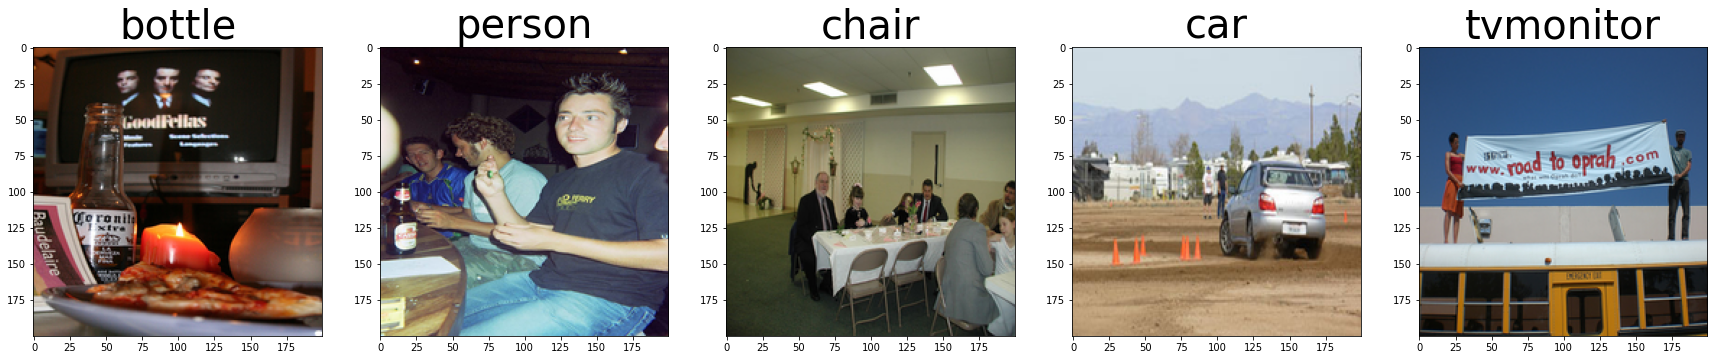

In [33]:
import matplotlib.pyplot as plt
from PIL import Image 
import os
import csv
from math import ceil

DATA_DIR = os.environ.get('LOCAL_DATA_DIR')
DATA_DOWNLOAD_DIR = os.environ.get('LOCAL_DATA_DIR')
csv_path = os.path.join(DATA_DIR, 'split', 'test', 'person', 'result.csv')
results = []
with open(csv_path) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        results.append((row[0], row[1]))

w,h = 200,200
fig = plt.figure(figsize=(30,30))
columns = 5
rows = 1
for i in range(1, columns*rows + 1):
    ax = fig.add_subplot(rows, columns,i)
    img = Image.open(results[i][0].replace(DATA_DOWNLOAD_DIR, DATA_DIR))
    img = img.resize((w,h), Image.ANTIALIAS)
    plt.imshow(img)
    ax.set_title(results[i][1], fontsize=40)

## 10. Export and Deploy! <a class="anchor" id="head-10"></a>

In [34]:
!classification export \
            -m $LOCAL_EXPERIMENT_DIR/output_retrain/weights/resnet_$EPOCH.tlt \
            -o $LOCAL_EXPERIMENT_DIR/export/final_model.etlt \
            -k $KEY

Using TensorFlow backend.
Using TensorFlow backend.
2022-05-19 23:34:37,503 [INFO] root: Building exporter object.
2022-05-19 23:34:41,944 [INFO] root: Exporting the model.
2022-05-19 23:34:41,945 [INFO] root: Using input nodes: ['input_1']
2022-05-19 23:34:41,945 [INFO] root: Using output nodes: ['predictions/Softmax']
2022-05-19 23:34:41,945 [INFO] iva.common.export.keras_exporter: Using input nodes: ['input_1']
2022-05-19 23:34:41,945 [INFO] iva.common.export.keras_exporter: Using output nodes: ['predictions/Softmax']
NOTE: UFF has been tested with TensorFlow 1.14.0.
DEBUG: convert reshape to flatten node
DEBUG [/usr/local/lib/python3.6/dist-packages/uff/converters/tensorflow/converter.py:96] Marking ['predictions/Softmax'] as outputs
2022-05-19 23:35:14,283 [INFO] root: Export complete.
2022-05-19 23:35:14,283 [INFO] root: {
    "param_count": 10.028228,
    "size": 38.331543922424316
}


In [35]:
print('Exported model:')
print('------------')
!ls -lh $LOCAL_EXPERIMENT_DIR/export/

Exported model:
------------
total 39M
-rw-r--r-- 1 jupyter jupyter 39M May 19 23:34 final_model.etlt


### A. Int8 Optimization <a class="anchor" id="head-10-1"></a>
Classification model supports int8 optimization for inference in TRT. In order to use this, we must calibrate the model to run 8-bit inferences. This involves 2 steps

* Generate calibration tensorfile from the training data using tlt-int8-tensorfile
* Use tao <task> export to generate int8 calibration table.

*Note: For this example, we generate a calibration tensorfile containing 10 batches of training data.
Ideally, it is best to use at least 10-20% of the training data to calibrate the model.*

In [ ]:
!classification calibration_tensorfile -e $LOCAL_SPECS_DIR/classification_retrain_spec.cfg \
                                    -m 10 \
                                    -o $LOCAL_EXPERIMENT_DIR/export/calibration.tensor

Using TensorFlow backend.
Using TensorFlow backend.
2022-05-19 23:39:46,234 [INFO] __main__: Loading experiment spec at /home/jupyter/classification/specs/classification_retrain_spec.cfg
2022-05-19 23:39:46,236 [INFO] __main__: Setting up input generator.
Found 11667 images belonging to 20 classes.
Writing calibration tensorfile:  40%|████▊       | 4/10 [00:05<00:07,  1.32s/it]

In [ ]:
# Remove the pre-existing exported .etlt file.
!rm -rf $LOCAL_EXPERIMENT_DIR/export/final_model.etlt
!classification export \
            -m $LOCAL_EXPERIMENT_DIR/output_retrain/weights/resnet_$EPOCH.tlt \
            -o $LO_EXPERIMENT_DIR/export/final_model.etlt \
            -k $KEY \
            --cal_data_file $USER_EXPERIMENT_DIR/export/calibration.tensor \
            --data_type int8 \
            --batches 10 \
            --cal_cache_file $USER_EXPERIMENT_DIR/export/final_model_int8_cache.bin \
            -v 

### B. Generate TensorRT engine <a class="anchor" id="head-10-2"></a>
Verify engine generation using the `tao-converter` utility included with the docker.

The `tao-converter` produces optimized tensorrt engines for the platform that it resides on. Therefore, to get maximum performance, please instantiate this docker and execute the `tao-converter` command, with the exported `.etlt` file and calibration cache (for int8 mode) on your target device. The tao-converter utility included in this docker only works for x86 devices, with discrete NVIDIA GPU's. 

For the jetson devices, please download the tao-converter for jetson from the dev zone link [here](https://developer.nvidia.com/tao-converter). 

If you choose to integrate your model into deepstream directly, you may do so by simply copying the exported `.etlt` file along with the calibration cache to the target device and updating the spec file that configures the `gst-nvinfer` element to point to this newly exported model. Usually this file is called `config_infer_primary.txt` for detection models and `config_infer_secondary_*.txt` for classification models.

In [ ]:
!converter $LOCAL_EXPERIMENT_DIR/export/final_model.etlt \
               -k $KEY \
               -c $LOCAL_EXPERIMENT_DIR/export/final_model_int8_cache.bin \
               -o predictions/Softmax \
               -d 3,224,224 \
               -i nchw \
               -m 64 -t int8 \
               -e $LOCAL_EXPERIMENT_DIR/export/final_model.trt \
               -b 64